In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from logistics import new_cav_model , J_analytical_new, fourier_transform_matrix, fast_f_t
from logistics_exact_cavity import Driven_cavity_class,two_modes_cavity
from numpy.fft import fft,fftfreq
from scipy.interpolate import interp1d	

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.size'] = 14  


I am going to be dealing at the $ \gamma \tau = 1 $ case. I expect participation of more modes (spectral analysis should show some resonance with respect to the modes of the cavity $\omega_{n} = n\pi / \tau$ )

In [14]:
def spectrum (aw,initial):
    state = np.asarray(initial)
    a = aw.reshape(-1,2,2)
    a_dag = np.conjugate(np.transpose(a,axes=(0,2,1)))
    return np.einsum('i,tik,tkj,j -> t',state,a_dag,a,state)

In [2]:
gamma = 1
tau = 1
phi = 2*np.pi 
t_max = 100*tau
dt = tau/50
w_ref = np.sqrt(gamma/tau)

In [7]:
cavity = new_cav_model(gamma,phi,tau,0)
cavity.evolve(t_max,dt)
t,e = cavity.excited_state([1,0])
sigma=cavity.s_array
a_out = cavity.a_out_array


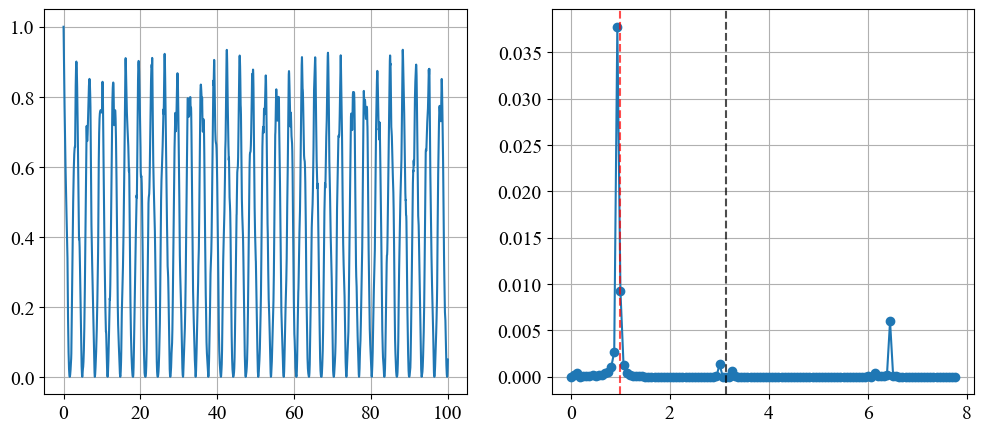

In [32]:
w,aw= fourier_transform_matrix(t,a_out,250)
spec = spectrum(aw,[1,0])

fig,axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(t,e)
axs[0].grid()

axs[1].plot(w,np.abs(spec),'-o')
axs[1].axvline(np.pi/tau,linestyle='--',color='k',alpha=0.7)
axs[1].axvline(w_ref,linestyle='--',color='r',alpha=0.7)
axs[1].grid()

plt.show()